<a href="https://colab.research.google.com/github/andreadosi1986/andreadosi/blob/master/ProgettoCariocaDlRun3SingValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install segmentation_models

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 06:55:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from matplotlib import rc
import skimage
from skimage.measure import regionprops
import random
import pandas as pd
from skimage import filters
import tifffile as tiff
import tensorflow as tf
import keras
import pickle

In [ ]:
### IMPORT TRAINING TEST SET AND CORRISPONDING LABELLING ####

In [ ]:
X_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_train4classes3SingVal.npy')

In [ ]:
X_test = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/X_test4classes3SingVal.npy')
y_train_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train_cat4classes3SingVal.npy')
y_test_cat = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_test_cat4classes3SingVal.npy')

In [ ]:
y_train = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_train4classes3SingVal.npy')
y_test = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/y_test4classes3SingVal.npy')

In [ ]:
print(X_train.shape, X_test.shape, y_train_cat.shape, y_test_cat.shape)

(4180, 128, 128, 3) (1046, 128, 128, 3) (4180, 128, 128, 4) (1046, 128, 128, 4)


In [ ]:
#class_weight_array = np.load('/content/drive/MyDrive/datamining/prisma/Sardinia/class_weight.npy')

In [ ]:
#print(class_weight_array)

In [ ]:
#classes = np.array([0,1,2,3,4,5])

In [ ]:
#class_weight = {0:class_weight_array[0], 1:class_weight_array[1], 2:class_weight_array[2], 3:class_weight_array[3], 4:class_weight_array[4], 5:class_weight_array[5]}

In [ ]:
#from tensorflow.python.keras.engine.training_utils_v1 import standardize_weights
#standardize_weights(classes, class_weight=class_weight)

In [ ]:
import segmentation_models as sm
#class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
#dice_loss = sm.losses.DiceLoss(class_weights=class_weight_array) 
focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)
#jaccard_loss = sm.losses.bce_jaccard_loss(class_weights=class_weight_array)

Segmentation Models: using `keras` framework.


In [ ]:
################################################################ U-NET BUILD ###########################################

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
n_classes=4

In [ ]:
#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
#model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
#model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])
#model.summary()

In [ ]:
#total_loss= weightedLoss(keras.losses.categorical_crossentropy, class_weights)
model = multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss= focal_loss, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
import time
start = time.time()

history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat), 
                    #sample_weight=class_weight_array,
                    shuffle=False)

print("Total model fit time: ", time.time() - start, "seconds")

Epoch 1/200
262/262 [==============================] - 27s 52ms/step - loss: 0.0127 - accuracy: 0.8399 - val_loss: 0.0085 - val_accuracy: 0.8833
Epoch 2/200
262/262 [==============================] - 12s 44ms/step - loss: 0.0057 - accuracy: 0.9012 - val_loss: 0.0044 - val_accuracy: 0.9152
Epoch 3/200
262/262 [==============================] - 12s 45ms/step - loss: 0.0034 - accuracy: 0.9309 - val_loss: 0.0036 - val_accuracy: 0.9307
Epoch 4/200
262/262 [==============================] - 12s 44ms/step - loss: 0.0023 - accuracy: 0.9494 - val_loss: 0.0021 - val_accuracy: 0.9521
Epoch 5/200
262/262 [==============================] - 12s 45ms/step - loss: 0.0018 - accuracy: 0.9580 - val_loss: 0.0019 - val_accuracy: 0.9568
Epoch 6/200
262/262 [==============================] - 12s 45ms/step - loss: 0.0016 - accuracy: 0.9634 - val_loss: 0.0019 - val_accuracy: 0.9590
Epoch 7/200
262/262 [==============================] - 12s 45ms/step - loss: 0.0014 - accuracy: 0.9665 - val_loss: 0.0015 - val_ac

In [ ]:
model.save('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_200Ep4Classes3ChannelsWithNoise2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_200Ep4Classes3ChannelsWithNoise2/assets


In [ ]:
#model_saved =  keras.models.load_model('/content/drive/MyDrive/datamining/prisma/Sardinia/deepUNet_200Ep4Classes3ChannelsWithNoise',compile=False)


In [ ]:
minutes_fit_time =(2456.1134254932404)/60
print(minutes_fit_time, "minutes")

40.93522375822067 minutes


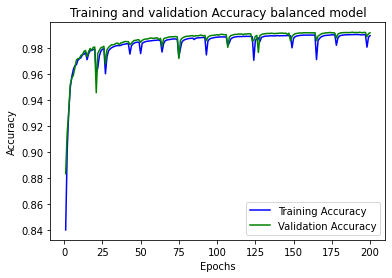

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and validation Accuracy balanced model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/content/drive/MyDrive/datamining/prisma/Sardinia/Accuracy.png", bbox_inches='tight')

plt.show()

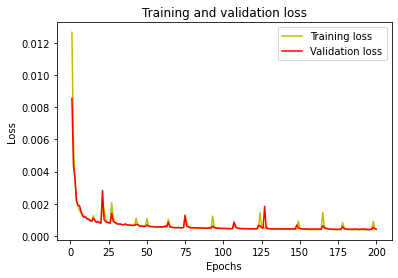

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/content/drive/MyDrive/datamining/prisma/Sardinia/LossFunction.png", bbox_inches='tight')
plt.show()

In [ ]:
#label_masks={0 : "background",1 : 'sea', 2 : "vegetation", 3 : "miner"} 

In [ ]:
prediction = model.predict(X_test)

In [ ]:
prediction.shape

(1046, 128, 128, 4)

In [ ]:
#predicted_img=np.argmax(prediction, axis=3)[45,:,:]

In [ ]:
predicted_img.shape

(128, 128)

PREDICTION


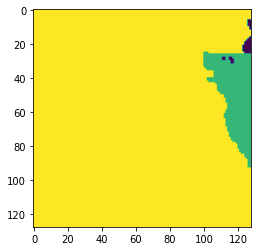

[0 2 3]
GROUND TRUTH


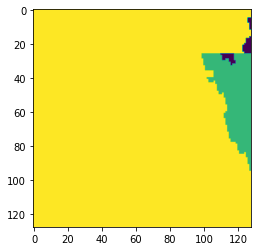

[0 2 3]


In [ ]:
from re import I
from random import randint
i = randint(0, 1046)
predicted_img=np.argmax(prediction, axis=3)[i,:,:]
print("PREDICTION")
plt.imshow(predicted_img)
plt.show()
print(np.unique(predicted_img))
print("GROUND TRUTH")
plt.imshow(y_test[i,:,:,0])
plt.show()
print(np.unique(y_test[i,:,:,0]))